# Capstone Webscrapping using BeautifulSoup

Notebook isi berisi mengenai langkah melakukan webscrapping data 50 judul, imdb rating, metascore, dan votes film terpopuler yang dirilis sepanjang 2021 pada website IMDB.

Versi: Oktober, 2021

## Background

Webscrapping merupakan kegiatan menggumpulkan data tidak terstruktur dari HTML. Salah satu library Python paling sering digunakan untuk parsing data HTML adalah `BeautifulSoup`, yang dapat diinstall menggunakan perintah `pip install beautifulsoup4`. Untuk keperluan capstone kali ini, library BeautifulSoup dapat diimpor dari `requirements.txt`.


In [3]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Requesting the Data and Creating a BeautifulSoup

Pertama, kita akan menggunakan modul `requests` untuk mendapatkan objek respons dari URL, lalu gunakan `requests.get()` pada url untuk memanggil halaman web.

In [4]:
import requests

url_get = requests.get('https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31')

Untuk menvisualisasikan apa yang didapatkan dari `requests.get`, kita dapat menggunakan `.content`. Jangan lupa slice HTML yang didapat dari halaman web agar tidak memenuhi layar. Slicing dapat dihapus untuk melihat semua konten HTML yang didapat.

In [5]:
url_get.content[1:500]

b'\n<!DOCTYPE html>\n<html\n    xmlns:og="http://ogp.me/ns#"\n    xmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n         \n\n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge">\n\n\n\n\n        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:\'java\'};</script>\n\n<script>\n    if (typeof uet == \'function\') {\n      uet("bb", "LoadTitle", {wb: 1});\n    }\n</script>\n  <script>(function(t){ (t.events = t.events || {})["csm_head_pre_'

Seperti yang dapat dilihat, HTML yang dipanggil sangat tidak terstruktur dan kompleks. HTML tersebut merupakan kode yang dibutuhkan untuk menunjukkan halaman web di browser web. Namun, sebagai manusia, kita akan asing dengan cara membaca kode tersebut. Oleh karena itu, kita menggunakan `beautifulsoup`. Kelas beautifulsoup akan menghasilkan objek beautifulsoup. BeautifulSoup mengubah dokumen HTML kompleks menjadi objek Python tree kompleks.

Mari kita buat objek BeautifulSoup menggunakan konten HTML yang telah kita scrape dan tipe parser yang diinginkan.

In [6]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content,"html.parser")

## Finding the right key to scrap the data & Extracting the right information

### Inspecting Element

Langkah inspect element:

1. Kembali ke website yang dituju,
2. Klik kanan elemen dalam web, lalu klik Inspect,
3. Developer tools akan terbuka dan menghighlight elemen yang kita right-click,
4. Klik kanan code element di developer tools, lalu copy.

Dari inspect element, ternyata kunci yang dibutuhkan berada di dalam tag `'div'` dalam atribut `class lister list`. `div` merupakan tag yang mendefinisikan divisi atau pembagian di sebuah dokumen HTML. `div` populer karena fleksibel dan mudah digunakan bersama dengan atribut classs atau id. 

### Finding Element

Kita dapat menggunakan metode `find` pada objek beautifulsoup. Mari kita panggil objek tersebut untuk melihat apa yang didapatkan.

In [7]:
table = soup.find('div', attrs={'class':'lister-list'})
print(table.prettify()[1:500])

# bs4 mempercantik tampilan html yang diambil, 1:500 artinya dislice sebanyak 500 kata

div class="lister-list">
 <div class="lister-item mode-advanced">
  <div class="lister-top-right">
   <div class="ribbonize" data-caller="filmosearch" data-tconst="tt10919420">
   </div>
  </div>
  <div class="lister-item-image float-left">
   <a href="/title/tt10919420/">
    <img alt="Squid Game" class="loadlate" data-tconst="tt10919420" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BYWE3MDVkN2EtNjQ5MS00ZDQ4LTliNzYtMjc2YWMzMDEwMTA3XkEyXkFqcGdeQXVyMTEzMTI1Mjk3._V1_UX67_CR0,0,67,


Dari baris yang diekstraksi, kita mendapat semua konten yang dibutuhkan. 
- Fungsi `find()`: membantu untuk mendapatkan bagian dari kode HTML yang dibutuhkan. Walaupun sebagian besar HTML berada dalam `div`, kita dapat membedakan mereka dengan bantuan `attrs=`, kita dapat memasukkan apapun yan berada dalam div untuk mencari bagian yang dibutuhkan.

Sekarang kita mendapatkan empat informasi yang diinginkan, yaitu judul, imdb_rating, metascore, dan voting. Keempat ini dapat kita baca di kode di atas, antara lain:

- `judul` berada dalam `h3` dengan atribut `'class lister-item-header'`
- `imdb_rating` berada dalam `div` dengan `'class inline-block ratings-imdb-rating'`
- `metascore` berada dalam `span` dengan `'class" "metascore favorable'`
- `voting` berada dalam `span` dengan `'name nv'`.

Sementara itu, fungsi mencari beautifulsoup antara lain:
- `find()`: **mencari tag pertama** dari nama atau id dan mengembalikan sebagai **objek** dari tipe bs4. Hasil berupa tree, masih bisa dichaining lagi.
- `find_all()`: digunakan untuk **mencari semua tag** pada nama taua id yang ditentukan dan mengembalikan sebagai **list** dengan tipe bs4. Hasil sudah final, tidak bisa dichain lagi karena berbentuk list.

### Checking the Length of the List

Sebelum looping, cari panjang data untuk membantu proses looping. Karena `find_all()` selalu menghasilkan data berbentuk list, kita akan menggunakan `len()` untuk mengecek panjang dari list.

In [8]:
row = table.find_all('h3', attrs={'class':'lister-item-header'})
row_length = len(row)
row_length

50

### (Optional) Looking for Missing Value

Missing value dapat menyebabkan error pada proses append data yang ditarik. Langkah ini dilakukan untuk mengecek satu persatu missing value pada setiap variabel. Alternatifnya, kita dapat langsung memanfaatkan fungsi `try` dan `if not`/`except` untuk imputasi missing value dengan "N/A". Setelah membuat DataFrame, jumlah missing value dapat dicari.

1. Judul

In [9]:
len(table.find_all('h3', attrs={'class':'lister-item-header'}))

50

>Ternyata, panjang list judul adalah 50. Tidak ada missing value.

2. IMDB Rating

In [10]:
len(table.find_all('div', attrs={"class": "inline-block ratings-imdb-rating"}))

48

>Sementara panjang data IMDB Rating sebanyak 47, terdapat 3 missing value.

3. Metascore

In [11]:
len(table.find_all("span", attrs={"class": "metascore favorable"}))

15

>Lalu, metascore ternyata sepanjang 15. Artinya, terdapat 35 missing value.

4. Votes

In [12]:
len(table.find_all("span", attrs={"name": "nv"}))

48

>Sama seperti IMDB Rating, variabel votes sepanjang 47 data dengan 3 missing value.

Ternyata, data `imdb_rating`, `metascore`, dan `votes` memiliki missing value. Oleh karena itu, perlu dilakukan imputasi.

### Looping through the Child Elements

Setelah mengetahui panjang data, proses looping dapat dilakukan, sebagai berikut:

1. Buat sebuah placeholder untuk menerima informasi yang kita scrap. Placeholder dinamai `temp`, dengan bentuk list.
2. Buat loop dari baris satu hingga sepanjang baris table.
3. Tarik data yang diinginkan yaitu judul, imdb_rating, metascore, dan voting.
4. Append data yang ditarik ke placeholder (tuple) `temp` yang telah disiapkan sebelumnya.
5. Setiap satu iterasi adalah satu baris dari table discrap.

In [13]:
temp = [] #initiating a tuple, wadah untuk menyimpan data. Biasa kita menggunakan list.

for i in range(0, row_length):
    try: 
        judul = table.find_all('h3', attrs={'class':'lister-item-header'})[i].a.text.strip()
    except Exception as e:
        judul = "N/A"
    try:
        imdb_rating = table.find_all('div', attrs={"class": "inline-block ratings-imdb-rating"})[i].strong.text
    except Exception as e:
        imdb_rating = "N/A"
    try:
        metascore = table.find_all("span", attrs={"class": "metascore favorable"})[i].text
    except Exception as e:
        metascore = "N/A"
    try:
        votes = table.find_all("span", attrs={"name": "nv"})[i].text
    except Exception as e:
        votes = "N/A"
    temp.append((judul, imdb_rating, metascore, votes))
# apppend: masukin hasil dari looping di i ke temp
temp 

[('Squid Game', '8.2', '68        ', '237,865'),
 ('No Time to Die', '7.6', '75        ', '123,661'),
 ('Dune: Part One', '8.3', '67        ', '160,614'),
 ('Maid', '8.5', '63        ', '27,321'),
 ('Halloween Kills', '5.9', '62        ', '35,435'),
 ('Midnight Mass', '7.8', '67        ', '56,754'),
 ('The Last Duel', '7.7', '77        ', '12,878'),
 ('Venom: Let There Be Carnage', '6.4', '71        ', '40,911'),
 ('The Guilty', '6.3', '69        ', '71,016'),
 ('Free Guy', '7.3', '75        ', '166,564'),
 ('Black Widow', '6.8', '61        ', '253,231'),
 ('Only Murders in the Building', '8.3', '67        ', '29,924'),
 ('The Chestnut Man', '7.9', '69        ', '18,913'),
 ('The Many Saints of Newark', '6.4', '72        ', '29,414'),
 ('Foundation', '7.4', '73        ', '19,229'),
 ('Chucky', '7.5', 'N/A', '3,446'),
 ('What If...?', '7.6', 'N/A', '55,319'),
 ('Dopesick', '8.6', 'N/A', '2,378'),
 ('Resident Evil: Welcome to Raccoon City', '8.0', 'N/A', '126'),
 ('Eternals', '8.6', 'N/A

> Tips: Hasil yang didapat sudah dapat dimasukkan ke Dataframe Pandas dan dianalisis. Tetapi, apabila data yang diberikan reversed, kita dapat menggunakan `::-1` untuk mensortir nilai data 

## Creating Data Frame & Data wrangling

Setelah menarik data dari HTML, hasil scraping berbentuk array akan kita simpan ke bentuk Dataframe. Missing values yang telah diimputasi dengan string 'N/A' akan kita ubah menjadi float 'NaN' agar data dapat divisualisasikan.

In [14]:
import numpy as np
import pandas as pd 
import matplotlib.image as mpimg
from matplotlib import rcParams

In [15]:
df = pd.DataFrame(temp, columns = ('judul', 'imdb_rating', 'metascore', 'votes')).replace('N/A',np.NaN)
df.head()

,judul,imdb_rating,metascore,votes
0,Squid Game,8.2,68,"237,865"
1,No Time to Die,7.6,75,"123,661"
2,Dune: Part One,8.3,67,"160,614"
3,Maid,8.5,63,"27,321"
4,Halloween Kills,5.9,62,"35,435"


Lalu, ubah kolom `judul` menjadi indeks.

In [16]:
df = df.set_index('judul')

Sebelum visualisasi data, pastikan data sudah bersih. Ternyata, tipe data masih berbentuk objek semua.

In [17]:
df.dtypes

imdb_rating    object
metascore      object
votes          object
dtype: object

 Oleh karena itu, kita kan mengganti tipe data `imdb_rating`, `metascore`, dan `votes` ke tipe data float64.

In [18]:
df['imdb_rating'] = df['imdb_rating'].astype('float64')
df['metascore'] = df['metascore'].astype('float64')
df['votes'] = df['votes'].str.replace(",","")
df['votes'] = df['votes'].astype('float64')

## Data Visualization

Setelah membersihkan data, kita akan melakukan visualisasi data untuk berkenalan dengan data yang telah ditarik. 

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

**Hanya Catatan**:
Untuk visualisasi, salah satu cara preprocessing yaitu dengan membuat dataframe baru dengan variabel yang dibutuhkan. Misalnya:

In [20]:
df1 = df.reindex(columns = ['votes','imdb_rating']).sort_values(by='imdb_rating', ascending=True).head(10)

### IMDB Rating Visualization

#### IMDB Rating Horizontal Bar Plot

<AxesSubplot:title={'center':'Top Ten IMDB Rating'}, ylabel='IMDB Rating'>

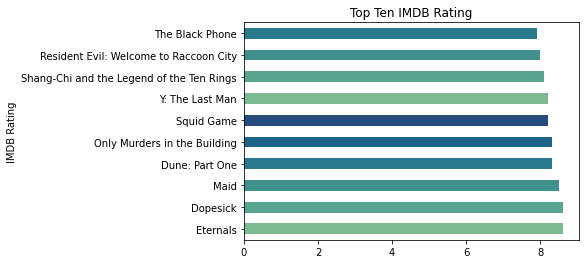

In [21]:
colors = sns.color_palette('crest')
vizbh_imdb = df['imdb_rating'].sort_values(ascending=False).head(10)
vizbh_imdb.plot.barh(color=colors[:10], title= 'Top Ten IMDB Rating', xlabel= 'IMDB Rating', ylabel = 'Title', stacked=True)

#### IMDB Rating Histogram Plot

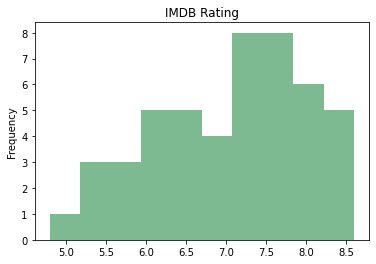

In [22]:
vizhist_imdb = df['imdb_rating'].plot.hist(color=colors, title= 'IMDB Rating')

In [23]:
df['imdb_rating'].mean()

7.070833333333333

In [24]:
df['imdb_rating'].std()

0.9569362310805303

#### IMDB Rating Density Plot

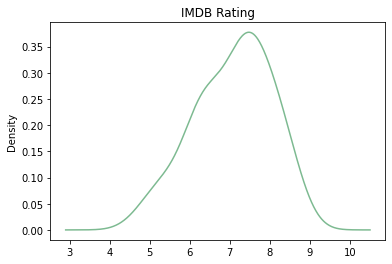

In [25]:
vizkde_imdb = df['imdb_rating'].plot.kde(color=colors, title= 'IMDB Rating')

### Metascore Visualization

#### Metascore Horizontal Bar Plot

<AxesSubplot:title={'center':'Top Ten Metascore'}, ylabel='metascore'>

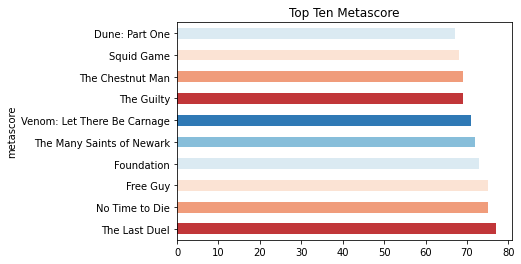

In [26]:
colors = sns.color_palette('RdBu')
vizbh_metascore = df['metascore'].sort_values(ascending=False).head(10)
vizbh_metascore.plot.barh(color=colors[:10], title= 'Top Ten Metascore', xlabel= 'metascore', ylabel = 'Title', stacked=True)

#### Metascore Histogram Plot

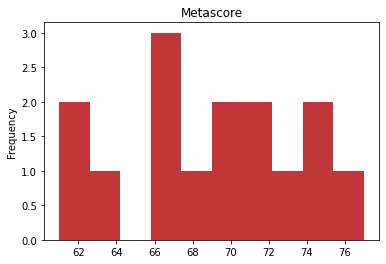

In [27]:
vizhist_metascore = df['metascore'].plot.hist(color=colors, title= 'Metascore')

#### Metascore Density Plot

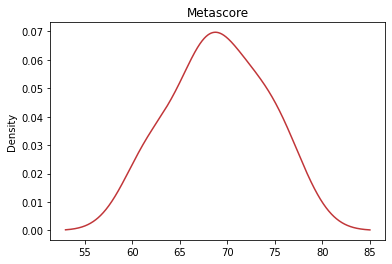

In [28]:
vizkde_metascore = df['metascore'].plot.kde(color=colors, title= 'Metascore')

### Votes Visualization

#### Votes Horizontal Bar Plot

<AxesSubplot:title={'center':'Top Ten Popular Movies by Number of Votes'}, ylabel='votes'>

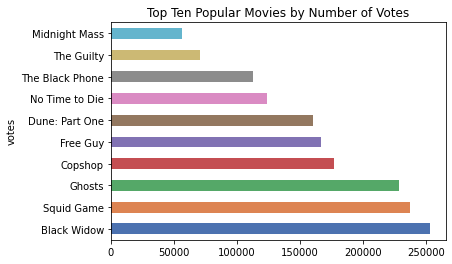

In [29]:
colors = sns.color_palette('deep')
vizbh_votes = df['votes'].sort_values(ascending=False).head(10)
vizbh_votes.plot.barh(color=colors[:10], title= "Top Ten Popular Movies by Number of Votes", xlabel= 'votes', ylabel = 'Title', stacked=True)

#### Votes Histogram Plot

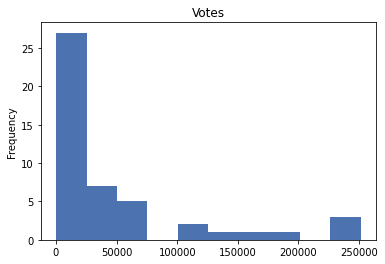

In [197]:
vizhist_votes = df['votes'].plot.hist(color=colors, title= 'Votes')

#### Votes Density Plot

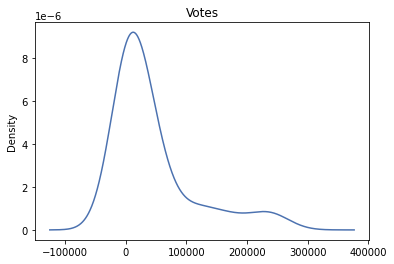

In [200]:
vizkde_votes = df['votes'].plot.kde(color=colors, title= 'Votes')

### Correlation between Two Variables

#### Correlation between Votes and IMDB Rating

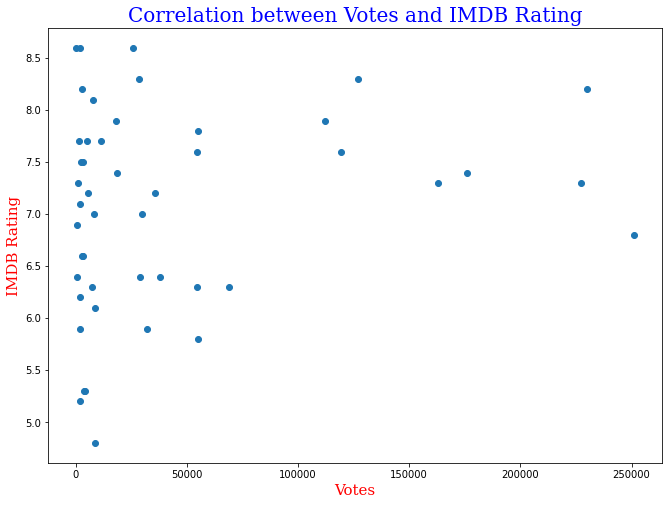

In [215]:
x1 = df['votes']
y1 = df['imdb_rating']
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'red','size':15}

plt.title("Correlation between Votes and IMDB Rating", fontdict = font1)
plt.xlabel("Votes", fontdict = font2)
plt.ylabel("IMDB Rating", fontdict = font2)

plt.scatter(x1, y1)
plt.show()

#### Correlation between IMDB Rating and Metascore

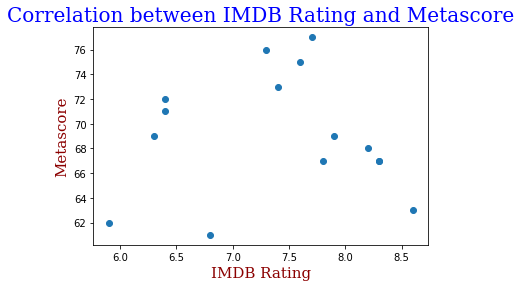

In [191]:
x2 = df['imdb_rating']
y2 = df['metascore']
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.title("Correlation between IMDB Rating and Metascore", fontdict = font1)
plt.xlabel("IMDB Rating", fontdict = font2)
plt.ylabel("Metascore", fontdict = font2)

plt.scatter(x2, y2)
plt.show()

In [193]:
(x2).corr(y2)

0.013905900978784887

### Implementing your webscrapping to the flask dashboard

- Copy paste all of your web scrapping process to the desired position on the `app.py`
- Changing the title of the dasboard at `index.html`

In [1]:
pip list --format=freeze > requirements1.txt

Note: you may need to restart the kernel to use updated packages.


## Finishing This Notebook with Your Analysis and Conclusion

**catatan**: sebaiknya bagian konklusi tidak diedit lagi karena properti gambar dapat hilang.

### IMDB Rating dan Metascore

#### Korelasi IMDB Rating dan Metascore

$$ Figur 1 $$
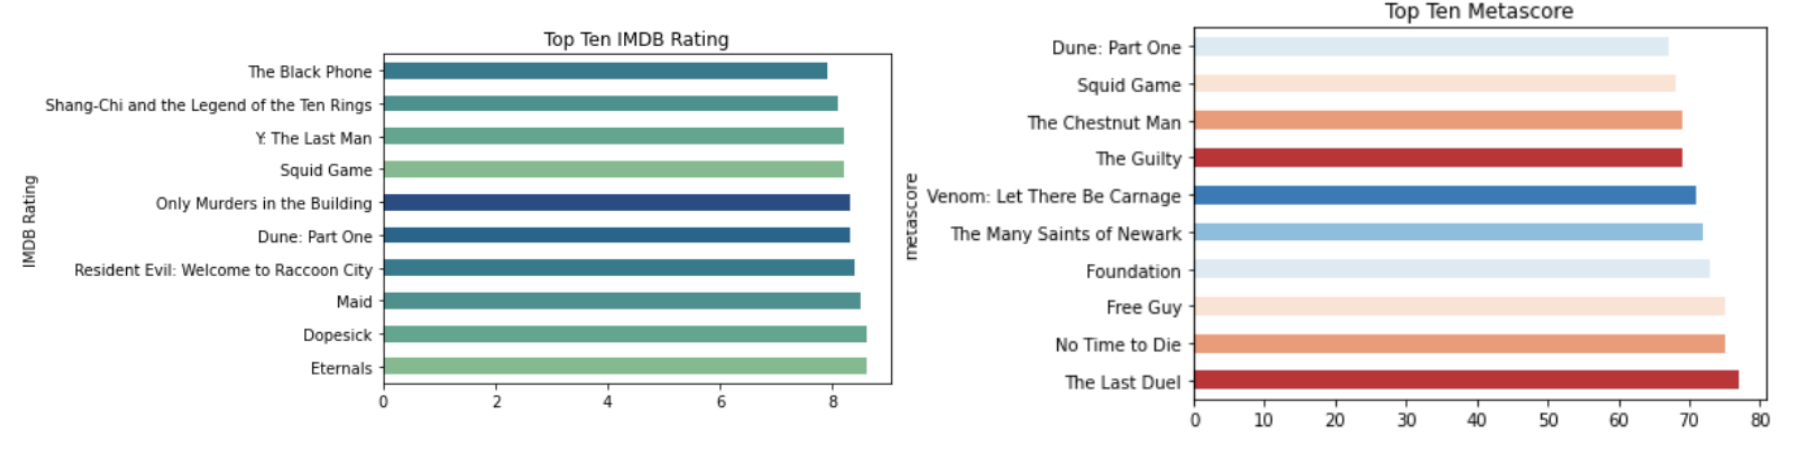


Tiga film perilisan tahun 2021 dengan rating IMDB tertinggi antara lain Eternals, Dopesick, dan Maid. Sementara itu, rating Metascore tertinggi pada film The Last Duel, No Time to Die, dan Free Guy. Hanya terdapat dua film yang sama-sama masuk sepuluh besar rating IMDB dan juga Metascore tertinggi, yaitu Squid Game di peringkat 7 IMDB Rating dan 9 Metascore, serta Dune: Part One di peringkat 5 IMDB Rating dan 10 di Metascore. Sisanya, sepuluh besar kedua rating memiliki observasi yang berbeda semua. Oleh karena itu, saya berhipotesis bahwa IMBD Rating tidak berkorelasi dengan Metascore, karena film yang memiliki IMDB rating tinggi belum tentu juga memiliki Metascore yang tinggi, demikian juga sebaliknya.

Dalam rangka membuktikan hipotesis, saya membuat scatterplot sederhana untuk menunjukkan korelasi antarvariabel secara kualitatif. Seperti yang dapat dilihat pada Figur 2, observasi tampak tersebar acak dalam scatterplot (tidak berkorelasi). Analisis kuantitatif juga menemukan bahwa korelasi antara IMDB Rating dan Metascore hanya sebesar 0,014 atau sangat lemah.  

$$ Figur 2 $$
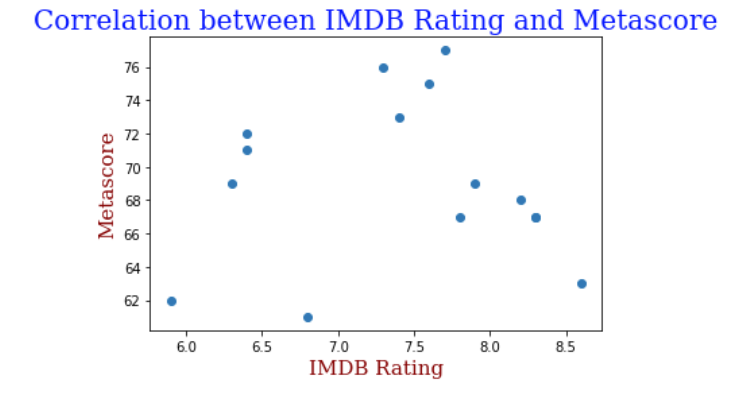


In [220]:
x2.corr(y2)

0.013905900978784887

#### Rating yang lebih terpercaya: IMDB Rating atau Metascore?
Setelah itu, saya penasaran rating apa yang lebih dapat dipercaya, apakah IMDB Rating atau Metascore. Kriteria yang dipakai untuk mengukur peratingan yang terbaik adalah bentuk distribusi data kedua rating. Rating dengan bentuk data yang mendekati distribusi normal (Gaussian) adalah rating yang lebih baik, karena berbagai fenomena di dunia, termasuk rating film, memiliki distribusi normal, i.e. dalam satu interval, kebanyakan observasi berada di tengah, dengan sedikit observasi di nilai ekstrem bawah atau atas (Figur 3). Artinya, rating dengan bentuk distribusi paling normal yang memiliki sampel paling mencerminkan populasi opini penonton film, yang selanjutnya mencerminkan kualitas film.

$$ Figur 3 $$
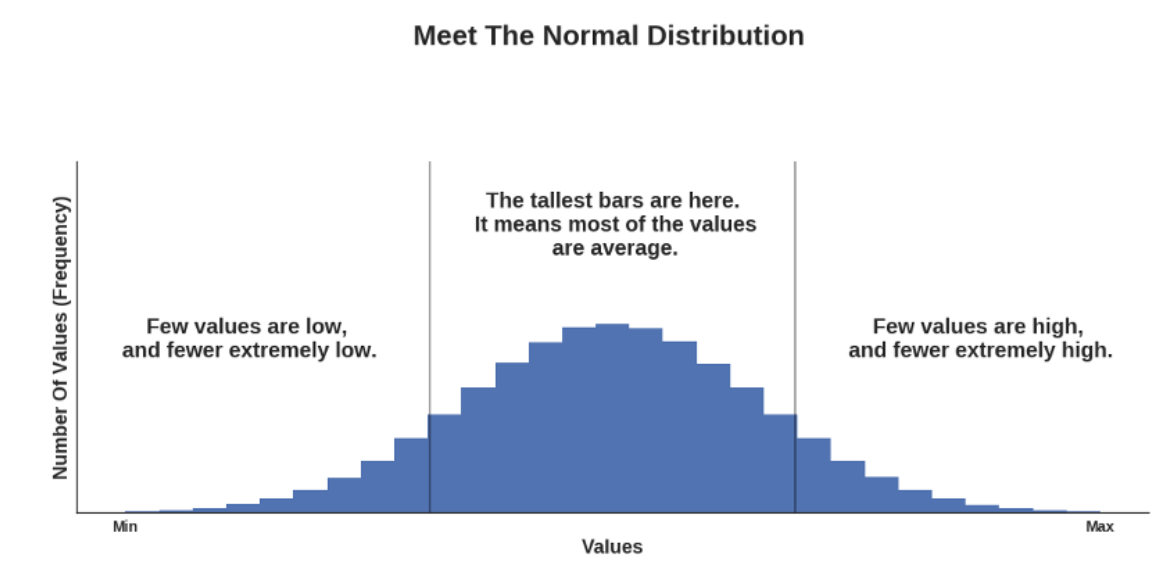

Berdasarkan grafik histogram dan density IMDB Rating pada Figur 4, dapat disimpulkan bahwa kurva distribusi agak condong ke kanan. Artinya, pengguna yang memberi votes di IMDB cenderung puas dengan 50 film terpopuler tahun 2021. Rata-rata rating IMDB adalah 7 dari 10, dengan standar deviasi 0,96.

$$ Figur 4 $$
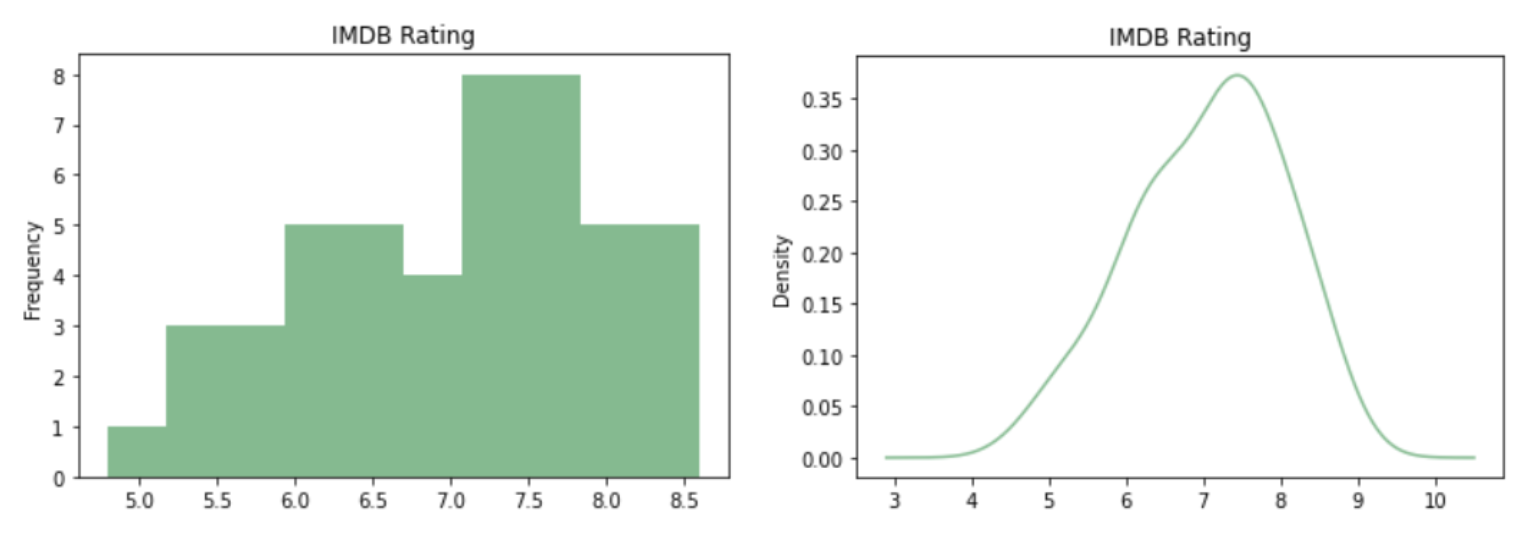

In [221]:
df['imdb_rating'].mean()

7.053191489361702

In [222]:
df['imdb_rating'].std()

0.9638805319778974

Sementara itu, grafik histogram dan density Metascore pada Figur 5 di bawah menunjukkan bahwa kurva distribusi termasuk normal. Artinya, pengguna Metascore sebagian besar lumayan puas dengan film yang ditonton, dengan sebagian kecil tidak puas dan sangat puas. Dari grafik density, dapat disimpulkan bahwa Metascore memiliki distribusi data yang lebih heterogen dibandingkan dengan IMDB Rating, dilihat dari lebar kurva lonceng Metascore yang lebih besar. Ini diperkuat dengan parameter kuantatif yaitu rata-rata Metascore adalah 69 dengan standar deviasi 4,9.

$$ Figur 6 $$
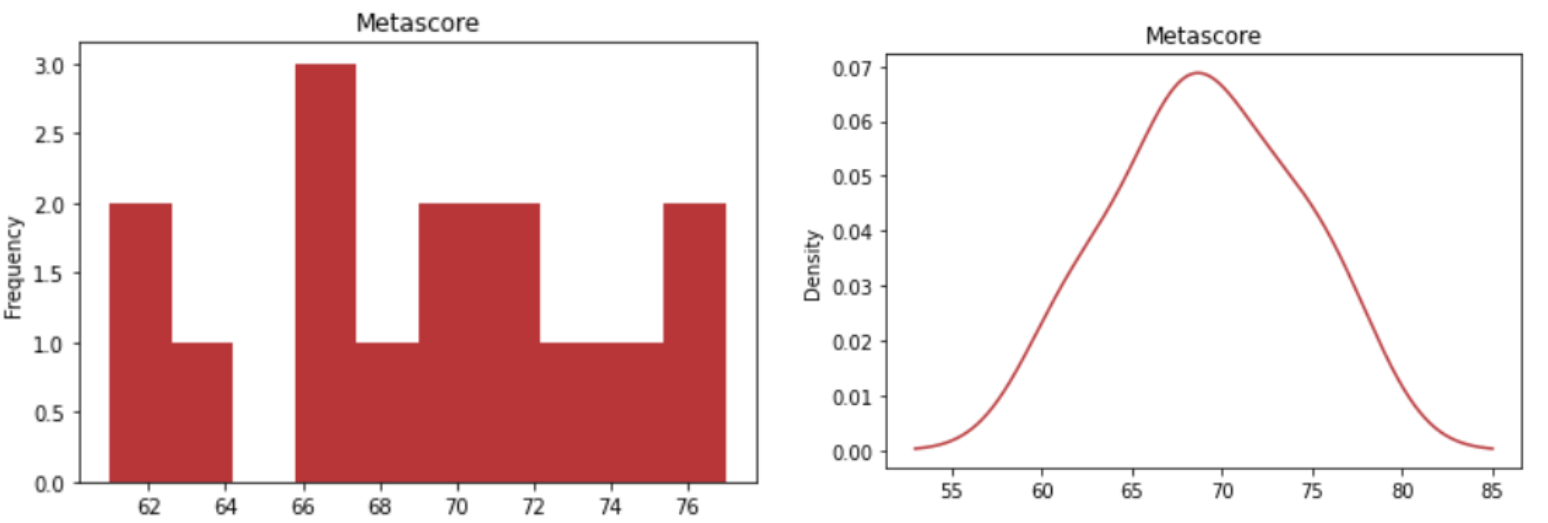

In [224]:
df['metascore'].mean()

69.13333333333334

In [225]:
df['metascore'].std()

4.926120853842978

Oleh karena itu, dapat disimpulkan bahwa Metascore merupakan rating yang lebih terpercaya dibandingkan IMDB Rating. 

Kelemahan analisis yaitu jumlah observasi Metascore yang hanya 15, sangat timpang dengan jumlah obervasi IMDB Rating sebanyak 47. Sampel yang diambil mungkin tidak mencerminkan populasi. Perbaikan yang dapat dilakukan yaitu dengan menambah jumlah observasi atau mencari nilai metascore yang rumpang di situs lain. 

### IMDB Rating dan Voting

Selanjutnya, kita juga memiliki data voting di situs IMDB. Sebelum melakukan analisis lebih lanjut, kita akan memvisualisasikan voting untuk melihat bentuk data.

$$ Figur 6 $$
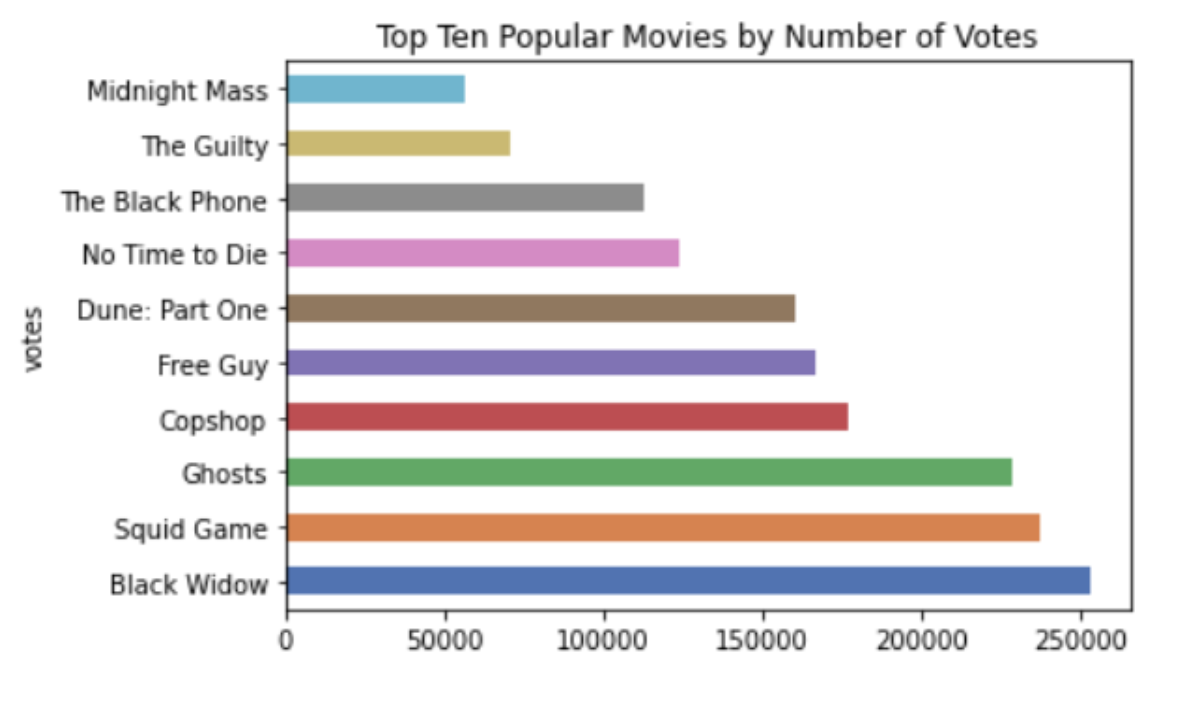

Berdasarkan figur 6, tiga film dengan votes terbanyak yaitu Black Widow, Squid Game, dan Ghosts. Jumlah votes pada suatu film dapat menjadi variabel proxy popularitas film tersebut. Artinya, semakin banyak jumlah votes, semakin populer film tersebut.

Lalu, kita melihat bentuk data dari grafik histogram dan density.

$$ Figur 7 $$
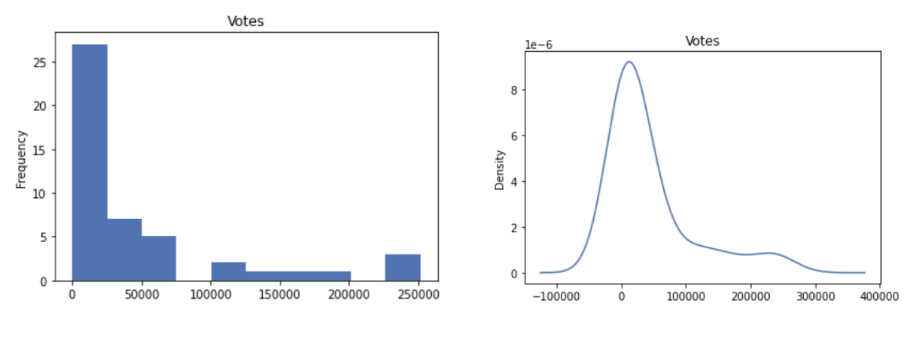

Ternyata, distribusi data condong ke kiri. Artinya, data tidak terdistribusi normal, terdapat banyak nilai data ekstrem atas. Bentuk distribusi film tersebut menunjukkan bahwa hanya sedikit film yang populer, dengan jarak popularitas yang jauh antara film paling terkenal seperti Dopesick dan film lain yang berada di rata-rata.

Oleh karena itu, nilai median lebih cocok untuk menggambarkan gejala pusat data, yaitu sebesar 8.509 dengan standar deviasi 66.551.

In [229]:
df['votes'].median()

8509.0

In [218]:
df['votes'].std()

66551.37632357758

Mungkin kita akan bertanya, apakah film dengan jumlah votes banyak akan memiliki rating tinggi juga? Dengan memplotting rating IMDB dan Voting dalam scatterplot, kita dapat melihat korelasi antara keduanya.

$$ Figur 6 $$

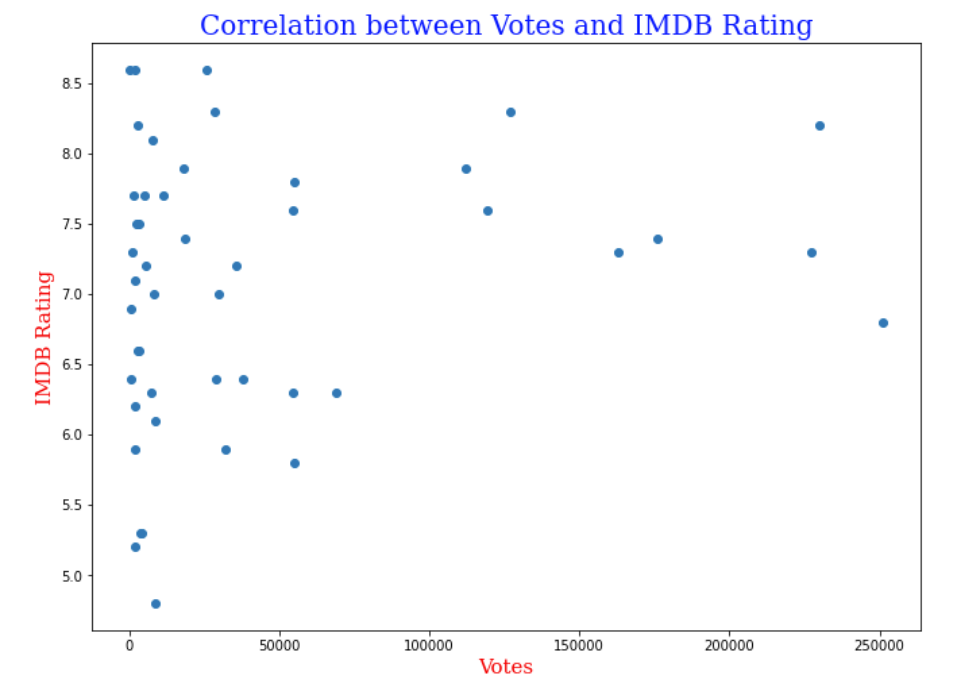

Ternyata, hanya terdapat korelasi lemah antara IMDB rating dan votes. Dari scatterplot dapat disimpulkan bahwa:

- Film dengan sedikit votes dapat memiliki rating rendah maupun tinggi 
- Film dengan votes banyak cenderung memiliki rating IMBD tinggi. Dapat disimpulkan bahwa film dengan kualitas bagus yang memiliki rating tinggi akan ditonton semakin banyak orang, sehingga votes juga bertambah banyak.

Agar lebih yakin, kita dapat menguji korelasi antara rating IMDB dan votes secara kuantitatif.

In [226]:
(x1).corr(y1)

0.1957234253034599

Hasil pengujian korelasi menunjukkan angka 0,2. Artinya, terdapat korelasi lemah antara rating IMDB dan votes. Melihat bentuk data demikian, ke depannya, mungkin penelitian dapat ditambahkan dengan analisis clustering menggunakan PCA sederhana, dengan tiga kluster yaitu:
- Film tidak terlalu populer dan tidak menarik (sedikit votes, rating rendah)
- Film tidak terlalu populer dan menarik (sedikit votes, rating tinggi)
- Film populer dan menarik (banyak votes, rating tinggi).

Hasil analisis dapat digunakan untuk beberapa hal, misalnya rekomendasi film yang tidak terlalu terkenal tapi sebenarnya bagus.

### Extra Challange

This will be not included to the scoring. 

- You can create additional analysis from the data.
- Implement it to the dashboard with at `app.py` dan `index.html`.